# Fine-tune pre-trained `ltrc-bigram` transformer model on Telugu dataset

## Installs

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

!pip install -q git+https://github.com/gmihaila/ml_things.git

  You can safely remove it manually.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Install matplotlib 3.1.3

In [2]:
pip install matplotlib==3.1.3

     ---------------------------------------- 40.9/40.9 MB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for matplotlib
Failed to build matplotlib
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [520 lines of output]
  Edit setup.cfg to change the build options
  
  BUILDING MATPLOTLIB
    matplotlib: yes [3.1.3]
        python: yes [3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC
                    v.1929 64 bit (AMD64)]]
      platform: yes [win32]
  
  OPTIONAL SUBPACKAGES
   sample_data: yes [installing]
         tests: no  [skipping due to configuration]
  
  OPTIONAL BACKEND EXTENSIONS
           agg: yes [installing]
         tkagg: yes [installing; run-time loading from Python Tcl/Tk]
        macosx: no  [Mac OS-X only]
  
  OPTIONAL PACKAGE DATA
          dlls: no  [skipping due to configuration]
  
  C:\Users\thris\AppData\Local\Programs\Python\Python310\lib\site-packages\setuptools\__init__.py:80: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!
  
          ***********************************************

## Imports

Import necessary libraries



In [3]:
import io
import os
import torch
import urllib
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from matplotlib import pyplot as plt
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (AutoConfig,
                          AutoModelForSequenceClassification,
                          AutoTokenizer, AdamW,
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )

## Declaration of parameters


Declare parameters used in this notebook

Load the review dataset

In [45]:
import pandas as pd

df = pd.read_csv("processed_data.csv")

# Print the first few rows of the DataFrame
print(df.head())

                                                text  target
0  ఒక్కొక్కరిని‌ 20 లక్షలు అడిగారని, సుపుత్రుడి ద...       0
1  ఆయా శాఖ అధికారులతో తక్షణమే నివేదిక తెప్పించుకొ...       1
2         దాదాపు 36 భారీ వాహనాలకు నిప్పు పెట్టారు.\n       0
3  ఇప్పుడు కొన్ని కీలక సన్నివేశాల విషయంలో చిరంజీవ...       0
4         అవి నాకు ఎన్నో సందర్భాల్లో ఉపయోగపడ్డాయి.\n       1


In [46]:
df.tail()

,text,target
12999,"ఆట ముగిసే సమయానికి వాడ్కర్‌, కర్నేవర్‌ (15) క్...",1
13000,"తప్పిపోయిన బాలికల తల్లిదండ్రుల పట్ల జాలి, దయ చ...",0
13001,ప్రధాని మోడీయే మరొకసారి ప్రధాని పదవి చేపట్టనున...,1
13002,ఈ కేసులో ప్రధాన నిందితుడైన వాసింను పోలీసులు అర...,1
13003,ఈ విజయం వారిదే.,1


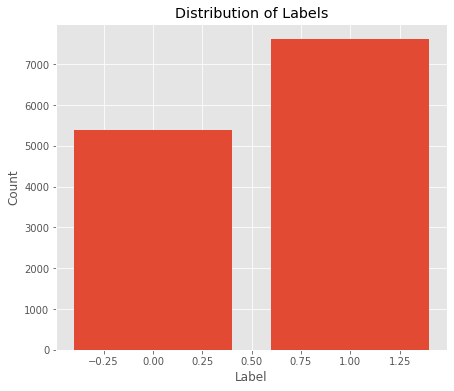

In [47]:
label_counts = df['target'].value_counts().sort_values(ascending=False)

#Extract labels and counts as separate lists
labels = list(label_counts.index)
counts = list(label_counts.values)

# Create the bar chart
fig, ax = plt.subplots(figsize=(7, 6))
plt.title('Distribution of Labels')
plt.bar(labels, counts)  # Use bar plot for categorical data with two labels
ax.set_ylabel('Count')
ax.set_xlabel('Label')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if needed
plt.show()

Split the data into train, test and validation sets

In [48]:
train, val, test = np.split(df.sample(frac=1), [int(.75*len(df)), int(.82*len(df))])

In [49]:
print ("Size of training dataset-->", len(train))
print ("Size of test dataset-->", len(test))
print ("Size of validation dataset-->", len(val))

Size of training dataset--> 9753
Size of test dataset--> 2341
Size of validation dataset--> 910


Extract training, testing and validation texts and labels

In [50]:
train_text = list(train ['text'])
train_labels = list(train ['target'])

test_text = list(test ['text'])
test_labels = list(test ['target'])

val_text = list(val ['text'])
val_labels = list(val ['target'])

Plot a historgram with the distribution of training labels

AttributeError: 'set' object has no attribute 'keys'

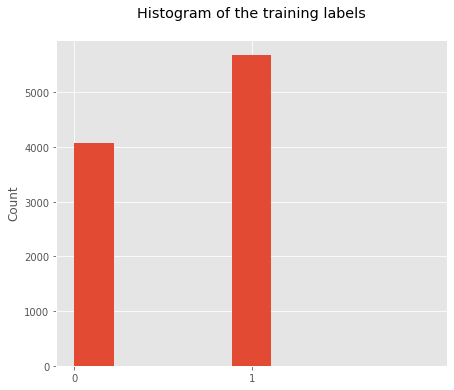

In [51]:
x = np.arange(n_labels)
bins = np.linspace(0, 2, 10)

fig, ax = plt.subplots(figsize=(7, 6))
plt.title('Histogram of the training labels\n')
plt.hist([train_labels], bins, label=['Training label'] )
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(list(labels_ids.keys()))
ax.legend(loc='lower right')
plt.show()

## Define helper class and functions

Classes and functions that are used in this notebook:

* MyDataset
* train
* validation

Define `MyDatset` class

In [52]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

**Define `train` function:**


Train a pytorch model on a single pass through the data loader. It will use the global variable `model` which is the transformer model loaded on `_device` that we want to train on.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].


See `Hugging Face` documentation on [training and fine-tuning transformers](https://huggingface.co/transformers/v3.5.1/training.html) in native PyTorch.

In [53]:
def train(dataloader, optimizer_, scheduler_, device_):

  # Use global variable for model
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch
  total_loss = 0

  # Put the model into training mode
  model.train()

  # For each batch of training data we run the loop
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch)
    # This will return the loss (rather than the model output) because we have provided the `labels`.
    # The documentation for a bert model function is here:
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple along with the logits.
    # We will use logits later to calculate training accuracy.
    #loss, logits = outputs[:2] # UNCOMMENT THIS IF YOU DON'T WANT TO CALCULATE THE LOSS YOURSELF

    # Alternatively, you can just get the logits and calculate the loss yourself as follows
    labels = batch.pop("labels")
    loss = F.cross_entropy(outputs.logits, labels)
    logits = outputs.logits


    # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end.
    # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients
    loss.backward()

    # Clip the norm of the gradients to 1.0. This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediction for future evaluations
  return true_labels, predictions_labels, avg_epoch_loss

**Define `validation` function:**

Validation function to evaluate model performance on a separate set of data. This function will return the true and predicted labels so we can use later to evaluate the model's performance.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]


In [54]:
def validation(dataloader, device_):

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch
  total_loss = 0

  # Put the model in evaluation mode (the dropout layers behave differently during evaluation)
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # Move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():

        # Forward pass, calculate logit predictions. This will return the logits rather than the loss because we have not provided labels.
        # `token_type_ids` is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple along with the logits.
        # We will use logits later to to calculate training accuracy.
        # loss, logits = outputs[:2] # UNCOMMENT THIS IF YOU DON'T WANT TO CALCULATE THE LOSS YOURSELF

        # Alternatively, you can just get the logits and calculate the loss yourself as follows
        labels = batch.pop("labels")
        loss = F.cross_entropy(outputs.logits, labels)
        logits = outputs.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end.
        # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()

        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

## Load config, tokenizer and the model

Loading the three esential parts of pretrained transformers:

* configuration,
* tokenizer and
* model.

We also need to load the model to the device we're planning to use (GPU / CPU).

In [55]:
# Get model configuration
print('Loading model configuraiton...')
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path,
                                          num_labels=n_labels)

# Get model's tokenizer
print('Loading model tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)

# Get the actual model
print('Loading the model...')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path,
                                                           config=model_config)

# Load model to the defined device
model.to(device)
print('Model loaded to `%s`'%device)

Loading model configuraiton...
Loading model tokenizer...
Loading the model...
Model loaded to `cuda`


## Data encoding and create DataLoader object

Create data encodings

In [56]:
train_encodings = tokenizer(train_text, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(val_text, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(test_text, truncation=True, padding=True, max_length=max_length)

train_dataset = MyDataset(train_encodings, train_labels)
valid_dataset = MyDataset(valid_encodings, val_labels)
test_dataset = MyDataset(test_encodings, test_labels)

Create DataLoader objects that will be fed into our model

In [57]:
train_dataloader = DataLoader (train_dataset, batch_size=batch_size, shuffle=True)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

test_dataloader = DataLoader (test_dataset, batch_size=batch_size, shuffle=False)
print('Created `test_dataloader` with %d batches!'%len(test_dataloader))

valid_dataloader = DataLoader (valid_dataset, batch_size=batch_size, shuffle=False)
print('Created `valid_dataloader` with %d batches!'%len(valid_dataloader))

Created `train_dataloader` with 610 batches!
Created `test_dataloader` with 147 batches!
Created `valid_dataloader` with 57 batches!


## Train the model

**Steps:**

1. Create optimizer and scheduler used by PyTorch in training

2. Loop through the number of defined epochs and call the **train** and **validation** functions

3. Store the outputs, which are similar info after each epoch as in Keras: *train_loss,   val_loss,   train_acc, valid_acc*

4. After training, plot train and validation loss and accuracy curves to check how the training went

In [58]:
optimizer = AdamW (model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                  no_deprecation_warning=True
                  )

# Total number of training steps is number of batches * number of epochs
# `train_dataloader` contains batched data so `len(train_dataloader)` gives us the number of batches
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup (optimizer,
                                            num_warmup_steps = 10, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}


# Loop through each epoch
print('Epoch')
for epoch in tqdm (range(epochs)):
  print()

  print('Training on batches...')
  # Perform one full pass over the training set
  train_labels, train_predict, train_loss = train (train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score (train_labels, train_predict)

  # Get prediction from model on validation data
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation (valid_dataloader, device)
  val_acc = accuracy_score (valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss values for plotting the learning curve
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)

  # Store the accuracy values
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

Epoch


  0%|          | 0/5 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/610 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/57 [00:00<?, ?it/s]

  train_loss: 0.70088 - val_loss: 0.68341 - train_acc: 0.56229 - valid_acc: 0.58132


Training on batches...


  0%|          | 0/610 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/57 [00:00<?, ?it/s]

  train_loss: 0.68856 - val_loss: 0.69203 - train_acc: 0.57111 - valid_acc: 0.58132


Training on batches...


  0%|          | 0/610 [00:00<?, ?it/s]

KeyboardInterrupt: 

Plot the loss and accuracy curves

In [ ]:
# Plot the loss curves
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_title='Loss curves', use_linestyles=['-', '--'], magnify=0.2)

# Plot the accuracy curves
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_title='Accuracy curves', use_linestyles=['-', '--'], magnify=0.2)